# Group 6 Proposal

## **Discriminating Between Sonar Signals Bounced Off a Metal Cylinder and Those Bounced Off a Roughly Cylindrical Rock**

## Introduction

Sonar is a technique that uses sound propagation characteristics to detect objects by emitting sound pulses and detecting or measuring their return after reflection, used as a means of acoustic location by measuring the echo characteristics of the object. Our project is based on identifying the differences between the sonar returns from an undersea metal cylinder and a cylindrically shaped rock

In our research we are trying to determine if there is any difference between the Sonar signals bounced off a metal cylinder and those bounced off a cylindrical rock. Thus, the question we will try to answer in our project: Is the object that bounces off a chosen sonar signal a metal cylinder or a cylindrical rock?

The dataset we will use contains signals bounced off a metal cylinder and a roughly cyclindrical rock obtained from a variety of different aspect angles. The angles spanned from 0 to 90 degrees for the metal cylinder and 0 to 180 degrees for the rock. The dataset does not list the explict aspect angles and states that the angles are not equally spaced apart. Thus each of the angles will be named AA_$n$ where $n$ is the $n$th variable. This is to reflect the fact that the angles do not have an explicit degree. The dataset does not list units for the return signal.

## Exploratory Analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
sonar <- read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data",
    col_names = FALSE)

set.seed(2022)

sonar_column_names <- c()
for (i  in 1:60) {
    sonar_column_names <- c(sonar_column_names, paste("AA", as.character(i), sep = "_"))
}
sonar_column_names <- c(sonar_column_names, "Rocks_or_Mines")

colnames(sonar) <- sonar_column_names

sonar <- sonar %>% mutate(Rocks_or_Mines = as_factor(Rocks_or_Mines))

sonar

Parsed with column specification:
cols(
  .default = col_double(),
  X61 = col_character()
)

See spec(...) for full column specifications.



AA_1,AA_2,AA_3,AA_4,AA_5,AA_6,AA_7,AA_8,AA_9,AA_10,⋯,AA_52,AA_53,AA_54,AA_55,AA_56,AA_57,AA_58,AA_59,AA_60,Rocks_or_Mines
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,⋯,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,⋯,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,⋯,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,⋯,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,⋯,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,⋯,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,R
0.0317,0.0956,0.1321,0.1408,0.1674,0.1710,0.0731,0.1401,0.2083,0.3513,⋯,0.0201,0.0248,0.0131,0.0070,0.0138,0.0092,0.0143,0.0036,0.0103,R
0.0519,0.0548,0.0842,0.0319,0.1158,0.0922,0.1027,0.0613,0.1465,0.2838,⋯,0.0081,0.0120,0.0045,0.0121,0.0097,0.0085,0.0047,0.0048,0.0053,R
0.0223,0.0375,0.0484,0.0475,0.0647,0.0591,0.0753,0.0098,0.0684,0.1487,⋯,0.0145,0.0128,0.0145,0.0058,0.0049,0.0065,0.0093,0.0059,0.0022,R


In [3]:
sonar_split <- initial_split(sonar, prop = 0.75, strata = Rocks_or_Mines)
sonar_training <- training(sonar_split)
sonar_testing <- testing(sonar_split)

###### Table 1: Sonar Training Dataset

In [4]:
sonar_training 

AA_1,AA_2,AA_3,AA_4,AA_5,AA_6,AA_7,AA_8,AA_9,AA_10,⋯,AA_52,AA_53,AA_54,AA_55,AA_56,AA_57,AA_58,AA_59,AA_60,Rocks_or_Mines
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,⋯,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,⋯,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,⋯,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,⋯,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,R
0.0317,0.0956,0.1321,0.1408,0.1674,0.1710,0.0731,0.1401,0.2083,0.3513,⋯,0.0201,0.0248,0.0131,0.0070,0.0138,0.0092,0.0143,0.0036,0.0103,R
0.0519,0.0548,0.0842,0.0319,0.1158,0.0922,0.1027,0.0613,0.1465,0.2838,⋯,0.0081,0.0120,0.0045,0.0121,0.0097,0.0085,0.0047,0.0048,0.0053,R
0.0223,0.0375,0.0484,0.0475,0.0647,0.0591,0.0753,0.0098,0.0684,0.1487,⋯,0.0145,0.0128,0.0145,0.0058,0.0049,0.0065,0.0093,0.0059,0.0022,R
0.0164,0.0173,0.0347,0.0070,0.0187,0.0671,0.1056,0.0697,0.0962,0.0251,⋯,0.0090,0.0223,0.0179,0.0084,0.0068,0.0032,0.0035,0.0056,0.0040,R
0.0123,0.0309,0.0169,0.0313,0.0358,0.0102,0.0182,0.0579,0.1122,0.0835,⋯,0.0133,0.0265,0.0224,0.0074,0.0118,0.0026,0.0092,0.0009,0.0044,R


###### Table 2: Sonar Testing Dataset

In [5]:
sonar_testing

AA_1,AA_2,AA_3,AA_4,AA_5,AA_6,AA_7,AA_8,AA_9,AA_10,⋯,AA_52,AA_53,AA_54,AA_55,AA_56,AA_57,AA_58,AA_59,AA_60,Rocks_or_Mines
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,⋯,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,⋯,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
0.0039,0.0063,0.0152,0.0336,0.0310,0.0284,0.0396,0.0272,0.0323,0.0452,⋯,0.0062,0.0120,0.0052,0.0056,0.0093,0.0042,0.0003,0.0053,0.0036,R
0.0270,0.0092,0.0145,0.0278,0.0412,0.0757,0.1026,0.1138,0.0794,0.1520,⋯,0.0084,0.0010,0.0018,0.0068,0.0039,0.0120,0.0132,0.0070,0.0088,R
0.0126,0.0149,0.0641,0.1732,0.2565,0.2559,0.2947,0.4110,0.4983,0.5920,⋯,0.0092,0.0035,0.0098,0.0121,0.0006,0.0181,0.0094,0.0116,0.0063,R
0.0664,0.0575,0.0842,0.0372,0.0458,0.0771,0.0771,0.1130,0.2353,0.1838,⋯,0.0141,0.0190,0.0043,0.0036,0.0026,0.0024,0.0162,0.0109,0.0079,R
0.0100,0.0275,0.0190,0.0371,0.0416,0.0201,0.0314,0.0651,0.1896,0.2668,⋯,0.0088,0.0104,0.0036,0.0088,0.0047,0.0117,0.0020,0.0091,0.0058,R
0.0240,0.0218,0.0324,0.0569,0.0330,0.0513,0.0897,0.0713,0.0569,0.0389,⋯,0.0162,0.0146,0.0093,0.0112,0.0094,0.0054,0.0019,0.0066,0.0023,R
0.0084,0.0153,0.0291,0.0432,0.0951,0.0752,0.0414,0.0259,0.0692,0.1753,⋯,0.0236,0.0114,0.0136,0.0117,0.0060,0.0058,0.0031,0.0072,0.0045,R


All the columns except Rocks_or_Mines are numerical variables. Rocks_or_Mines is catagorical variable.

#### Data Summary

###### Table 3: Observation counts, average values of first five sonar angles for metal and rock objects

In [6]:
sonar %>%
group_by(Rocks_or_Mines) %>%
summarize(num_observ = n(), AA_1_mean = mean(AA_1), AA_2_mean = mean(AA_2), AA_3_mean = mean(AA_3), AA_4_mean = mean(AA_4), AA_5_mean = mean(AA_5))

`summarise()` ungrouping output (override with `.groups` argument)



Rocks_or_Mines,num_observ,AA_1_mean,AA_2_mean,AA_3_mean,AA_4_mean,AA_5_mean
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R,97,0.02249794,0.03030309,0.03595052,0.04144742,0.06202784
M,111,0.03498919,0.04554414,0.05071982,0.06476757,0.08671532


Note: Although each of the 60 angles are useful when it comes to predicting the material type, due to the large number of angles, only the first five are shown in table 3.


#### Exploratory Data Visualization

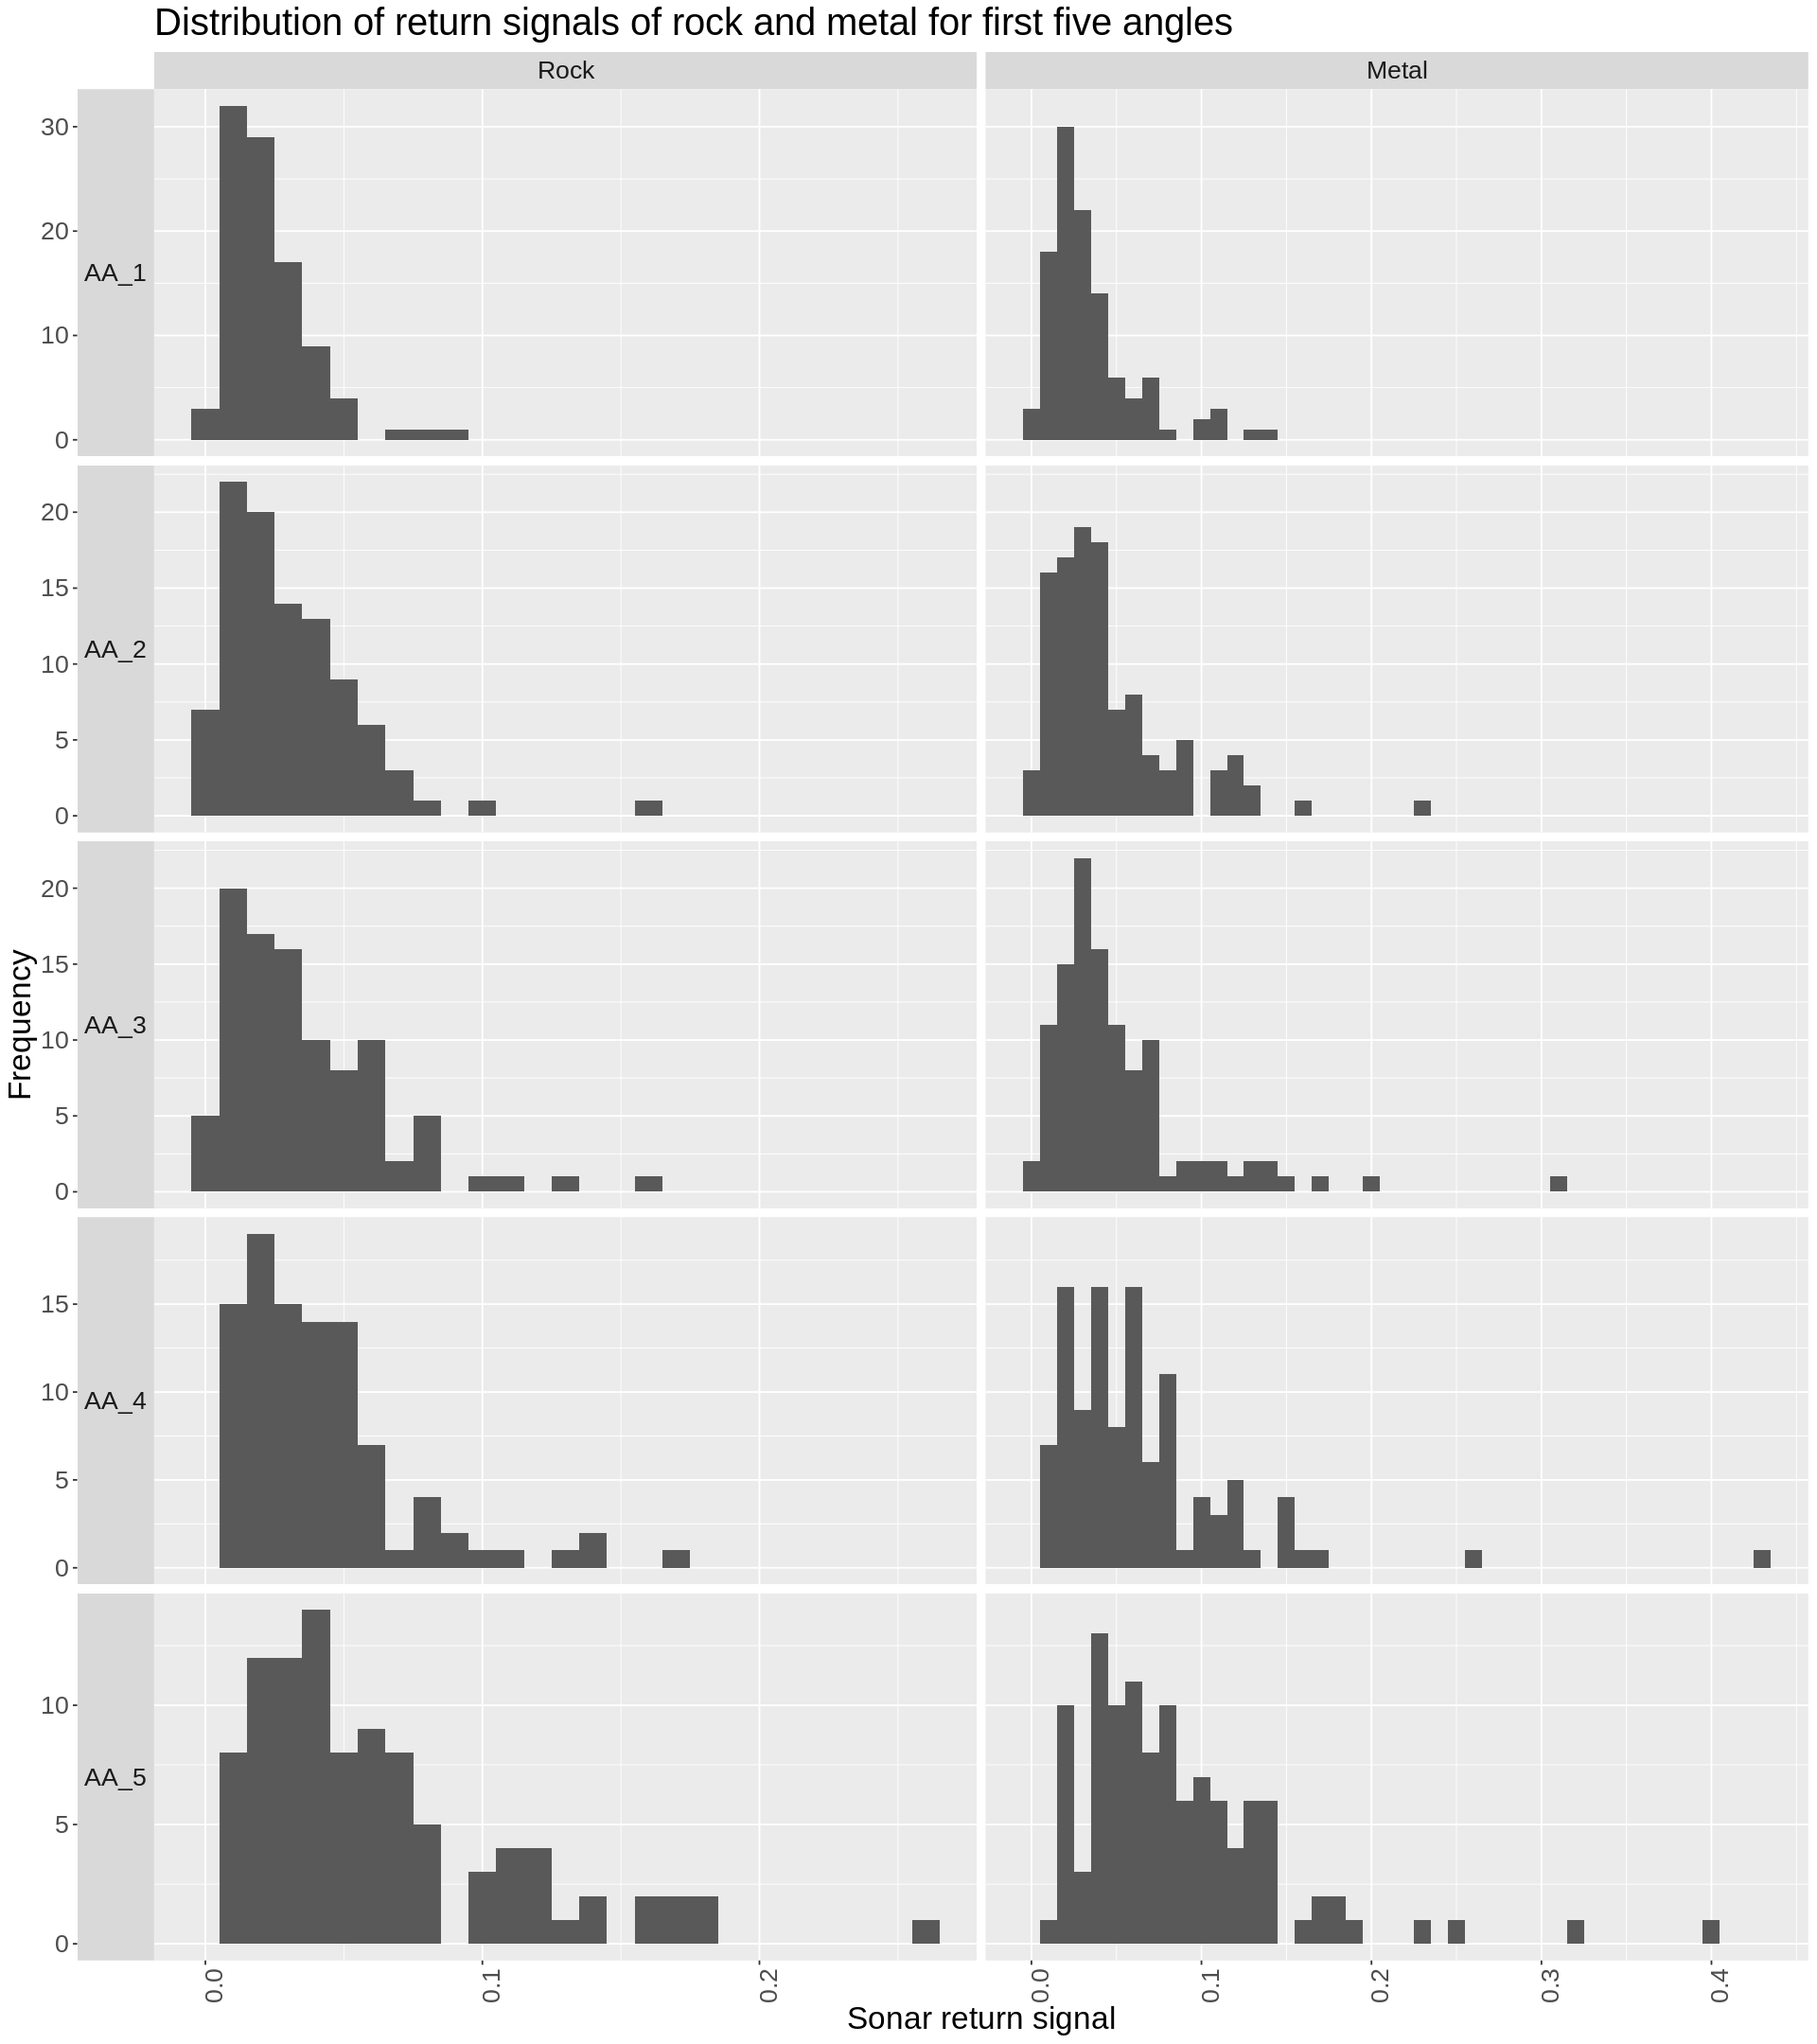

In [7]:
options(repr.plot.width = 16, repr.plot.height = 18)
sonar_longer <- pivot_longer(sonar,
            cols = AA_1:AA_60,
            names_to = "angle",
            values_to = "return_measurement") %>%
            filter(angle == "AA_1" | angle == "AA_2" | angle == "AA_3" | angle == "AA_4" | angle == "AA_5") %>%
            mutate(angle = as_factor(angle)) %>%
            mutate(Rocks_or_Mines = recode(Rocks_or_Mines, R = "Rock", M = "Metal"))

sonar_longer %>% ggplot(aes(x = return_measurement)) + 
   geom_histogram(binwidth = 0.01) +
   xlab("Sonar return signal") + 
   ylab("Frequency") +
   labs(title = "Distribution of return signals of rock and metal for first five angles") +
   facet_grid(angle ~ Rocks_or_Mines, scales = "free",
              switch = "y") +
   theme(axis.text.x = element_text(angle = 90, hjust = 1),
        strip.text.y.left = element_text(angle = 0),
        text = element_text(size = 20))

Again note that although each of the 60 angles are useful when it comes to predicting the material type, due to the large number of angles, only the first five are shown.

## Methods

To conduct are data analysis, we will use all the columns. Even though it is not ideal to use all the columns for data analysis in many cases, in our case the columns named AA_1 to AA_60 represent 60 different features used to identify whether the object that bounces of a chosen sonar signal a metal cylinder or a cylindrical rock. Each of these 60 features are equally important to discriminate between the sonar signals.

Since we have a large number of features, one way we will use to visualize our results is by using a Principal Component Analysis (PCA) plot. A PCA plot is the analysis of the linear components of all existing attributes of a data set and it is primarily used to better visualize the variations present in a dataset with many variables.

## Expected Outcomes and Significance

We expect that there is some clustering pattern with sonar measurements and a KNN clustering model should be able to reasonably predict if an unknown object is metal or rock given a vector of 60 sonar measurements.


Predicting the object's material from sonar measurements is usually done by humans. The findings listed above could show that this process can be automated and perhaps be done with higher accuracy.


This dataset only has metal and rock as object categories. It would be interesting to see if clustering model could be applied to a larger range of material types.

The clustering model will have an accuracy. It would also be interesting to see if other types of predictive models could be trained to have a higher accuracy.